In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from pandas.tseries.offsets import MonthBegin

# Pegue os dados do Kaggle

In [2]:
inflation_train = pd.read_csv('inflation_train.csv', index_col=0)
inflation_train

,Infl
ID,
1970-02-01,5.109489
1970-03-01,3.472222
1970-04-01,2.396932
1970-05-01,2.153558
1970-06-01,1.924840
...,...
2022-08-01,1.216173
2022-09-01,0.859394
2022-10-01,0.520710


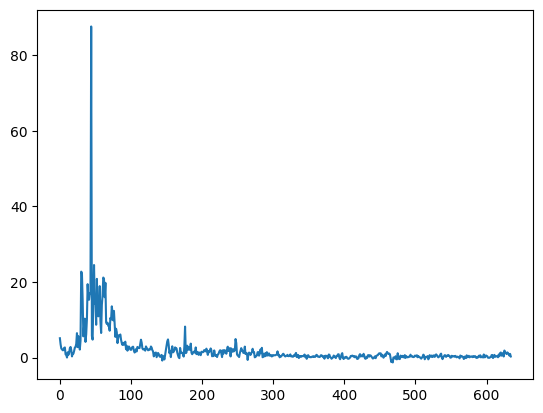

In [3]:
plt.plot(inflation_train.values)

# Arrume o que for necessário e rode o modelo 

In [40]:
# --- 0) Índice em datetime ---
inflation_train.index = pd.to_datetime(inflation_train.index)

# --- 1) Ajuste AutoARIMA usando toda a série de treino ---
model_full = pm.auto_arima(
    inflation_train['Infl'].values,
    seasonal=False,      # sem componente sazonal
    start_p=0,           # começa testando p=0
    start_q=0,           # começa testando q=0
    max_p=6,            # até AR(12)
    max_q=6,            # até MA(12)
    max_order=24,        # p+q<24
    d=None,              # deixa o auto_arima escolher d via ADF
    information_criterion='bic',
    trace=True,
    stepwise=False,       # busca stepwise para acelerar
    suppress_warnings=True,
    error_action='ignore',
    #n_jobs=-1    #paraleliza na CPU mas não plota todos os resultados
)
print("=== Summary do AutoARIMA (treino completo) ===")
print(model_full.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=3762.873, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=3450.767, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=3456.864, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : BIC=3459.491, Time=0.17 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : BIC=3464.049, Time=0.21 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : BIC=3465.087, Time=0.25 sec
 ARIMA(0,1,6)(0,0,0)[0] intercept   : BIC=3470.376, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=3632.096, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=3456.933, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=3462.704, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : BIC=3465.468, Time=0.28 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : BIC=3466.242, Time=0.41 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : BIC=3471.076, Time=0.32 sec
 ARIMA(1,1,6)(0,0,0)[0] intercept   : BIC=3476.800, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=3562.411, Time=0.07 sec
 ARIMA(2,1

In [41]:
# Faça a previsão dos valores

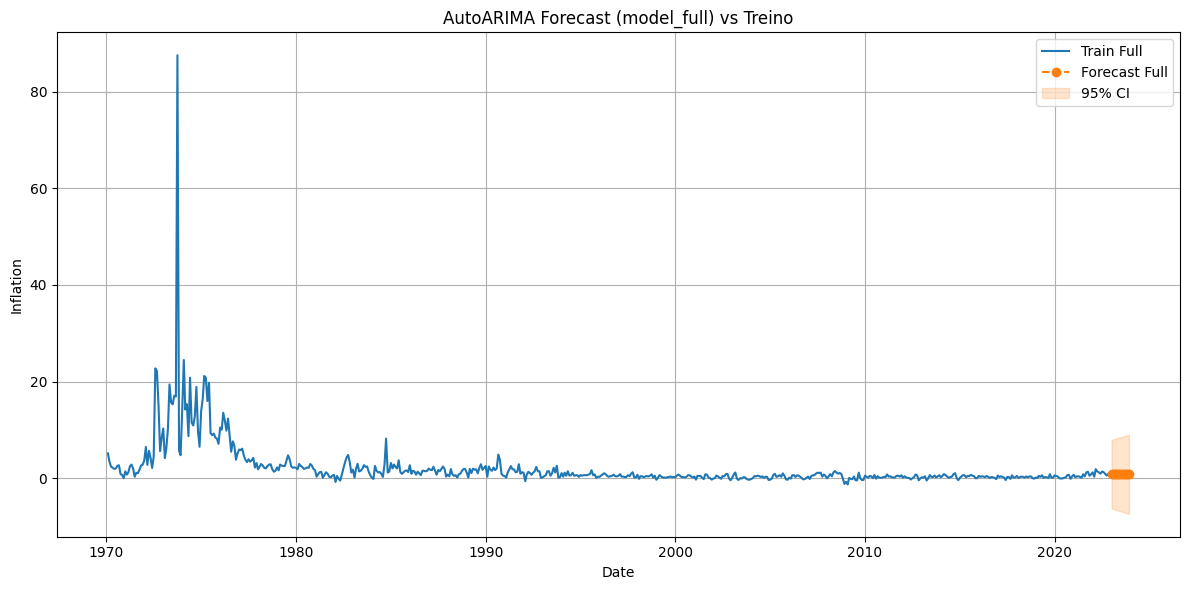

In [42]:
# --- 1) Forecast de 12 meses com model_full ---
n_periods = 12
fc_full, confint_full = model_full.predict(n_periods=n_periods, return_conf_int=True)

# Constrói o índice das datas de forecast
last_date = inflation_train.index[-1]
start     = last_date + MonthBegin(1)
idx_full  = pd.date_range(start=start, periods=n_periods, freq='MS')

# Série de previsão
forecast_full = pd.Series(fc_full, index=idx_full, name='Forecast_Full')

# --- 2) Plotagem ---
plt.figure(figsize=(12, 6))

# Série completa de treino
plt.plot(inflation_train.index, inflation_train['Infl'],
         label='Train Full', color='C0')

# Forecast do model_full
plt.plot(forecast_full.index, forecast_full.values,
         '--', marker='o', label='Forecast Full', color='C1')
plt.fill_between(
    idx_full,
    confint_full[:, 0],
    confint_full[:, 1],
    color='C1',
    alpha=0.2,
    label='95% CI'
)

plt.title('AutoARIMA Forecast (model_full) vs Treino')
plt.xlabel('Date')
plt.ylabel('Inflation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

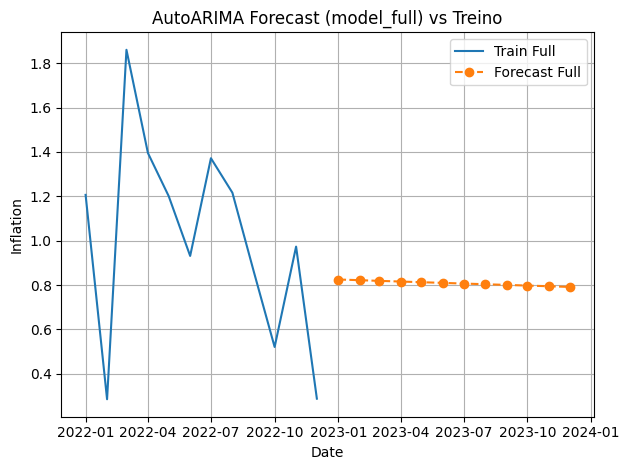

In [45]:
# Série completa de treino
plt.plot(inflation_train[-12:].index, inflation_train['Infl'][-12:],
         label='Train Full', color='C0')
# Forecast do model_full
plt.plot(forecast_full.index, forecast_full.values,
         '--', marker='o', label='Forecast Full', color='C1')
#plt.fill_between(
#    idx_full,
#    confint_full[:, 0],
#    confint_full[:, 1],
#    color='C1',
#    alpha=0.2,
#    label='95% CI'
#)

plt.title('AutoARIMA Forecast (model_full) vs Treino')
plt.xlabel('Date')
plt.ylabel('Inflation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Como submeter?

Tem que ter essa cara, coluna com "ID" para os datas e "infl" para os valores. Arquivo .csv

In [47]:
forecast_df = forecast_full.reset_index()
forecast_df.columns = ['ID', 'infl']
forecast_df

#forecast_df.to_csv('forecast_full.csv', index=False)

,ID,infl
0,2023-01-01,0.824879
1,2023-02-01,0.821837
2,2023-03-01,0.818796
3,2023-04-01,0.815754
4,2023-05-01,0.812712
5,2023-06-01,0.809671
6,2023-07-01,0.806629
7,2023-08-01,0.803587
8,2023-09-01,0.800546
9,2023-10-01,0.797504
